In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MultiLabelBinarizer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, classification_report, roc_auc_score, roc_curve)



In [9]:
df = pd.read_csv('../../data/Database_Cleaned.csv')

df['Release_Quarter'] = df['Month'].apply(lambda x: (x-1)//3 + 1 if pd.notna(x) else np.nan)
df['Is_Summer_Release'] = df['Month'].apply(lambda x: 1 if x in [6, 7, 8] else 0)
df['Is_Holiday_Release'] = df['Month'].apply(lambda x: 1 if x in [11, 12] else 0)
df['Votes_Per_Point'] = df['Vote_Count'] / (df['Vote_Average'] + 0.01) # Avoid division by zero
df['High_Rating'] = (df['Vote_Average'] >= 7.0).astype(int)

In [11]:
labelEncode = LabelEncoder()

# Encode language
df['Language_Encoded'] = labelEncode.fit_transform(df['Original_Language'].fillna('unknown'))

# Encode primary genre
df['Genre_Encoded'] = labelEncode.fit_transform(df['Primary_Genre'])

In [14]:
feature_cols = ['Popularity', 'Vote_Count', 'Genre_Count', 'Year', 'Month',
                'Language_Encoded', 'Genre_Encoded', 'Is_Summer_Release',
                'Is_Holiday_Release']
# Prepare data
df_classification = df.dropna(subset=['High_Rating'] + feature_cols)
X_clf = df_classification[feature_cols]
y_clf = df_classification['High_Rating']


In [16]:
# Split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42, stratify=y_clf
)

# Scale features
scaler_clf = StandardScaler()
X_train_clf_scaled = scaler_clf.fit_transform(X_train_clf)
X_test_clf_scaled = scaler_clf.transform(X_test_clf)


In [17]:
# Train classification models
models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=10, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
}

results_clf = {}

for name, model in models_clf.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_clf_scaled, y_train_clf)

    # Predictions
    y_pred_train = model.predict(X_train_clf_scaled)
    y_pred_test = model.predict(X_test_clf_scaled)

    # Metrics
    train_acc = accuracy_score(y_train_clf, y_pred_train)
    test_acc = accuracy_score(y_test_clf, y_pred_test)
    test_precision = precision_score(y_test_clf, y_pred_test, zero_division=0)
    test_recall = recall_score(y_test_clf, y_pred_test, zero_division=0)
    test_f1 = f1_score(y_test_clf, y_pred_test, zero_division=0)

    results_clf[name] = {
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Precision': test_precision,
        'Recall': test_recall,
        'F1 Score': test_f1,
        'Model': model
    }

    print(f"Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f} | Recall: {test_recall:.4f} | F1: {test_f1:.4f}")




Training Logistic Regression...
Train Acc: 0.7173 | Test Acc: 0.7146
Precision: 0.6721 | Recall: 0.2543 | F1: 0.3690

Training Decision Tree...
Train Acc: 0.8218 | Test Acc: 0.7533
Precision: 0.6600 | Recall: 0.5116 | F1: 0.5764

Training Random Forest...
Train Acc: 0.8430 | Test Acc: 0.7726
Precision: 0.7845 | Recall: 0.4233 | F1: 0.5498


In [18]:
# Compare classification models
comparison_clf = pd.DataFrame({
    'Model': list(results_clf.keys()),
    'Test Accuracy': [v['Test Accuracy'] for v in results_clf.values()],
    'Precision': [v['Precision'] for v in results_clf.values()],
    'Recall': [v['Recall'] for v in results_clf.values()],
    'F1 Score': [v['F1 Score'] for v in results_clf.values()]
})
comparison_clf = comparison_clf.sort_values('F1 Score', ascending=False)
print(comparison_clf.to_string(index=False))

              Model  Test Accuracy  Precision   Recall  F1 Score
      Decision Tree       0.753306   0.660000 0.511628  0.576419
      Random Forest       0.772635   0.784483 0.423256  0.549849
Logistic Regression       0.714649   0.672131 0.254264  0.368954


In [19]:
# Best model
best_model_clf_name = comparison_clf.iloc[0]['Model']
best_model_clf = results_clf[best_model_clf_name]['Model']
print(f"Best Model: {best_model_clf_name}")
print(f"Test Accuracy: {results_clf[best_model_clf_name]['Test Accuracy']:.4f}")
print(f"F1 Score: {results_clf[best_model_clf_name]['F1 Score']:.4f}")

Best Model: Decision Tree
Test Accuracy: 0.7533
F1 Score: 0.5764


## Need To check

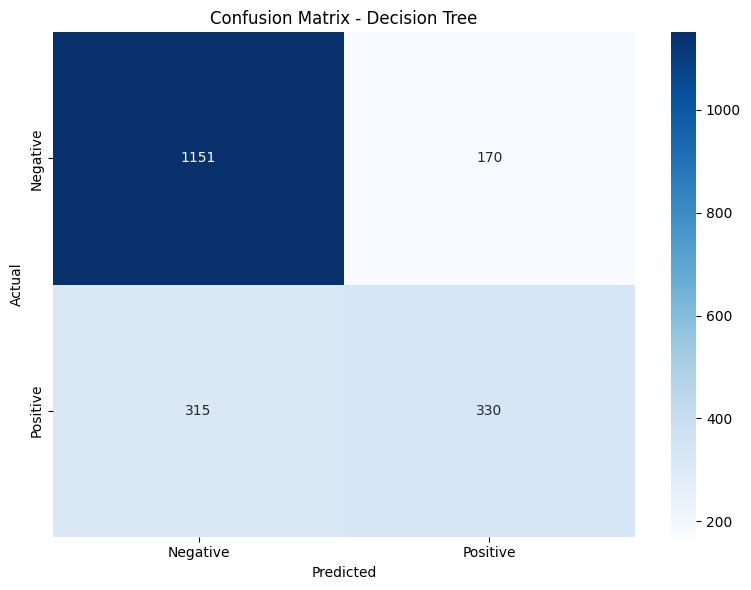

In [23]:
# Confusion Matrix
y_pred_clf_best = best_model_clf.predict(X_test_clf_scaled)
cm = confusion_matrix(y_test_clf, y_pred_clf_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_clf_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.show()

              precision    recall  f1-score   support

  Low Rating       0.79      0.87      0.83      1321
 High Rating       0.66      0.51      0.58       645

    accuracy                           0.75      1966
   macro avg       0.72      0.69      0.70      1966
weighted avg       0.74      0.75      0.74      1966



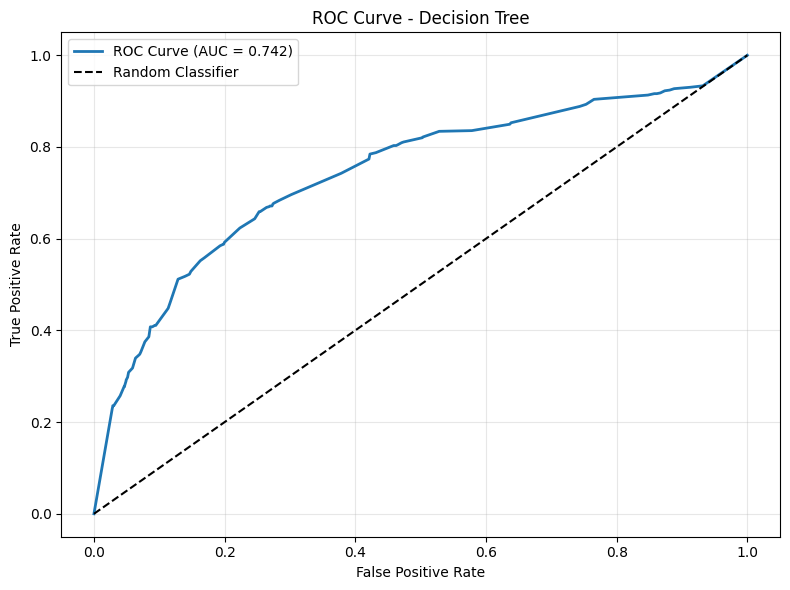


AUC-ROC Score: 0.7419


In [26]:
# Classification Report
print(classification_report(y_test_clf, y_pred_clf_best,
                          target_names=['Low Rating', 'High Rating']))

# ROC Curve (if probability predictions available)
if hasattr(best_model_clf, 'predict_proba'):
    y_pred_proba = best_model_clf.predict_proba(X_test_clf_scaled)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test_clf, y_pred_proba)
    auc = roc_auc_score(y_test_clf, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_model_clf_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nAUC-ROC Score: {auc:.4f}")


Top 10 Important Features:
           Feature  Importance
        Vote_Count    0.322789
              Year    0.229324
     Genre_Encoded    0.172699
  Language_Encoded    0.124755
        Popularity    0.065185
       Genre_Count    0.041800
             Month    0.034529
 Is_Summer_Release    0.005194
Is_Holiday_Release    0.003724


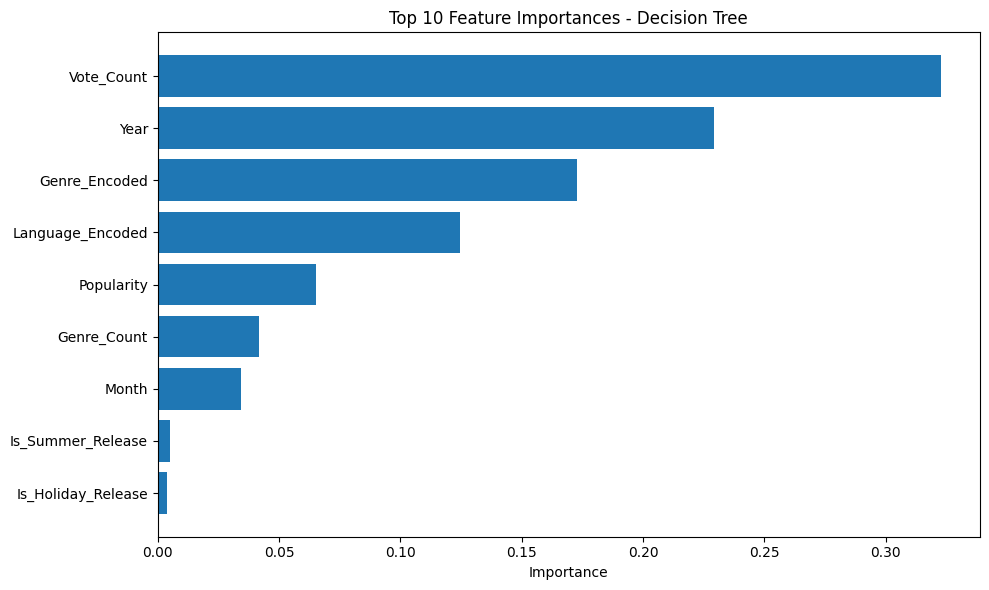

In [27]:
# Feature importance (for tree-based models)
if hasattr(best_model_clf, 'feature_importances_'):
    feature_importance_clf = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': best_model_clf.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\nTop 10 Important Features:")
    print(feature_importance_clf.head(10).to_string(index=False))

    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_clf.head(10)['Feature'],
             feature_importance_clf.head(10)['Importance'])
    plt.xlabel('Importance')
    plt.title(f'Top 10 Feature Importances - {best_model_clf_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


# MULTI-CLASS CLASSIFICATION

In [30]:
# Use only top 5 genres for simplicity
top_5_genres = df['Primary_Genre'].value_counts().head(5).index.tolist()
df_genre = df[df['Primary_Genre'].isin(top_5_genres)].copy()


df_genre_clean = df_genre.dropna(subset=['Primary_Genre'] + feature_cols)
X_genre = df_genre_clean[feature_cols]
y_genre = df_genre_clean['Primary_Genre']

print(f"\nGenre Classification Dataset:")
print(f"Samples: {len(X_genre)}")
print(f"Features: {len(feature_cols)}")
print(f"Target: Primary_Genre (Top 5 Genres)")
print(f"\nGenre Distribution:")
print(y_genre.value_counts())


Genre Classification Dataset:
Samples: 6517
Features: 9
Target: Primary_Genre (Top 5 Genres)

Genre Distribution:
Primary_Genre
Drama        1791
Action       1570
Comedy       1484
Horror        868
Animation     804
Name: count, dtype: int64


In [31]:
# Split data
X_train_genre, X_test_genre, y_train_genre, y_test_genre = train_test_split(
    X_genre, y_genre, test_size=0.2, random_state=42, stratify=y_genre
)

# Scale features
scaler_genre = StandardScaler()
X_train_genre_scaled = scaler_genre.fit_transform(X_train_genre)
X_test_genre_scaled = scaler_genre.transform(X_test_genre)

Training Random Forest for Genre Classification

Test Accuracy: 1.0000


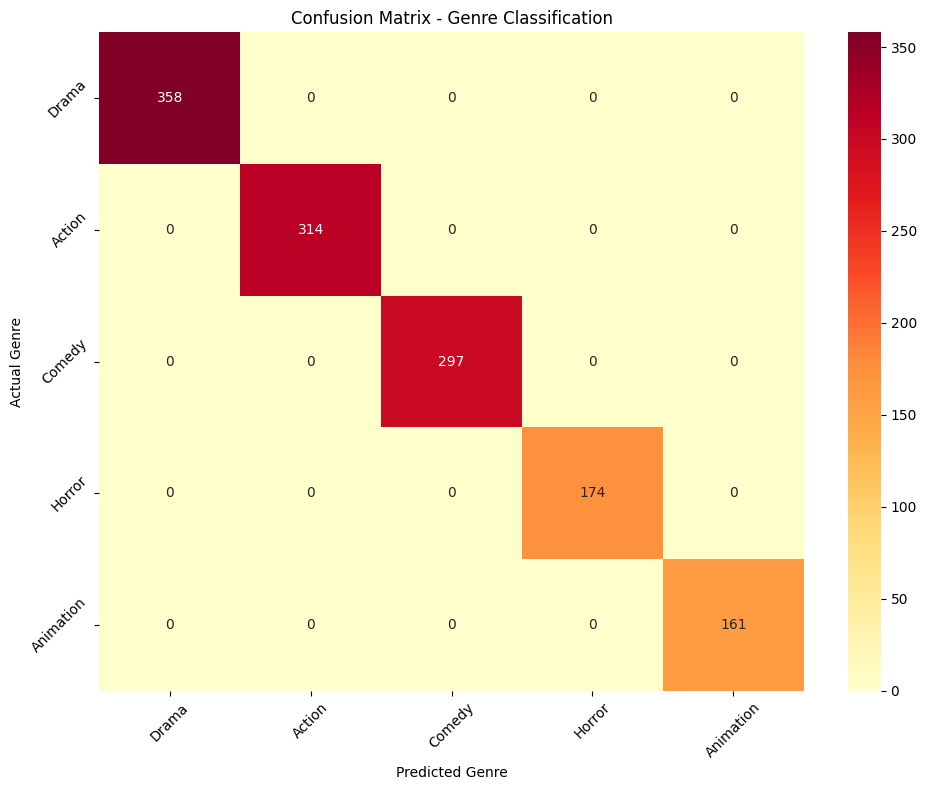

In [32]:
# Train model
print("Training for Genre Classification")
model_genre = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model_genre.fit(X_train_genre_scaled, y_train_genre)

# Predictions
y_pred_genre = model_genre.predict(X_test_genre_scaled)

# Metrics
acc_genre = accuracy_score(y_test_genre, y_pred_genre)
print(f"\nTest Accuracy: {acc_genre:.4f}")

# Confusion Matrix
cm_genre = confusion_matrix(y_test_genre, y_pred_genre, labels=top_5_genres)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_genre, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=top_5_genres, yticklabels=top_5_genres)
plt.title('Confusion Matrix - Genre Classification')
plt.ylabel('Actual Genre')
plt.xlabel('Predicted Genre')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()